In [2]:
import numpy as np; import matplotlib.pyplot as plt 
import seaborn as sns;import pymc3 as pm 
import theano ;import pandas as pd
from theano import shared, tensor as tt
import os

Couldn't import dot_parser, loading of dot files will not be possible.


In [1]:
from numpy import pi, log
def FechKal(x,y): 
    da2 = []
    y = y
    x_cumulative = np.cumsum(x)
    time_c = np.cumsum(y)
    x_cumulative_with_zero = np.insert(x_cumulative,
                                       0, 0)

    f_x = x_cumulative/x_cumulative.max()
    
    deltat = time_c[1:-1] - time_c[0:-2]
    
    da2_a = np.zeros([len(x)])
    da2_a[0] = (((f_x[0]**2 - 0**2))*np.pi)/(36*(deltat[0]))
    
    da2_a = ((f_x[1:-1]**2 - f_x[0:-2]**2)*np.pi)/(36*deltat)

    da2_b = np.zeros([len(x)])
    dif_f = f_x[1:-1] - f_x[0:-2]
    da2_b = (1/((np.pi**2)*deltat))*(-(np.pi*np.pi/3)*dif_f -
                                             (2*np.pi)*(np.sqrt(1 -(np.pi/3)*f_x[1:-1]) - np.sqrt(1 - (np.pi/3)*f_x[0:-2])))
    
    da2_c = np.zeros([len(x)])
    da2_c = (1/(np.pi*np.pi*deltat))*\
    np.log((1 - f_x[0:-2])/(1 - f_x[1:-1]))
    
    
    ka = f_x[(f_x <= 0.1) & (f_x > 0)]
    kb = f_x[(f_x > 0.1) & (f_x <= 0.9)]
    kc = f_x[(f_x > 0.9) & (f_x <= 1)]
    
    na = len(ka)
    nb = len(kb)
    nc = len(kc)
    
    a = da2_a[:na]
    b = da2_b[na:(nb + na)]
    c = da2_c[-nc:]
    da2.extend(a)
    da2.extend(b)
    da2.extend(c)
    
    return da2

In [25]:
# Import Cassata Gulf of Salerno

'''
Comparison with Frequentist Misfit statistical Method 
Model Test against known 
2-Domain model 
d1 = 0.75, d2 = 0.25
'''
cwd = os.getcwd()
os.chdir("/Users/jackcarter/Documents/Data_Mixtures")
df2 = pd.read_csv("Cassata_G_Sanidine.csv", engine = 'python')

In [26]:
temp  = df2['Temp'].values
time = df2['Time'].values
ar39 = df2['Ar39'].values
dr2 = FechKal(ar39, time)
tplot = 10000/(temp + 273.15)
tplot = tplot[:len(dr2)]
data = np.log(dr2)
qq = data
temp = (10000/tplot) - 273.15

In [27]:
X = temp + 273.15; qq = data
tplot = 10000/X; N = len(qq)
idx = np.linspace(0, N-1, N).astype(int)

In [28]:
x = X[:, np.newaxis]
data = qq[:, np.newaxis]
N = data.shape[0]
idx = np.linspace(0, N-1, N).astype(int)

# Non-Parametric 

In [29]:
import pymc3.distributions.transforms as tr
Q = pm.Model() 
k = 10
R = 8.314e-3
with Q: 
    
    phi = pm.Dirichlet('phi', 
                     a =  np.ones(k)/k, 
                      testval = np.ones(k)/k)
    
    phi_bound = pm.Potential('phi_bound', 
                            tt.switch(phi.min() < 0.05, 
                                     -np.inf, 0))
    
    z = pm.Categorical('z', p = phi, 
                      shape = N)

In [30]:
with Q: 

    # Diffusion Kinetics
    ea = pm.Normal('Ea', mu = 200, sd = 5)
    
    d0 = pm.HalfNormal('D0', sd = 50)
    
    # Grain effective Diffusive lengthscale 
    a = pm.HalfNormal('a', sd = 0.1, 
                   shape = k, 
                     testval = np.linspace(0.23, 1e-4, k))
    
    
    # Model
    mu = pm.Deterministic('model', 
                          tt.log(phi[z]**2*(d0/(a[z]**2)) \
                         * tt.exp(-ea/(R \
                                * X[idx]))))

# Added Constraints

In [31]:
#with Q: 
    
#########################################################################
    #for i in range(k - 1): 
    #    phi_con = pm.Potential(f'phi_con{i}',
    #                          tt.switch(phi[i+1] - phi[i] > 0, 
    #                                   -np.inf, 0))
#########################################################################   

# Normal Mixture Sum of Squares Likelihood

In [32]:
with Q: 
    sd = pm.HalfNormal('sd', sd = 1, shape = k)
    obs = pm.Normal('obs', mu, sd = sd[z],
                          observed = qq)
    

In [33]:
for RV in Q.basic_RVs: 
    print(Q.name, Q.logp(Q.test_point))

 -781.2475445655002
 -781.2475445655002
 -781.2475445655002
 -781.2475445655002
 -781.2475445655002
 -781.2475445655002
 -781.2475445655002


In [34]:
with Q: 
    step1 = pm.CategoricalGibbsMetropolis([z])
    step2 = pm.Metropolis([a, sd, phi, ea, d0])

    trace = pm.sample(200000, tune = 100000, 
                     step = [step1, step2], 
                      init = 'advi+adapt_diag')

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>CategoricalGibbsMetropolis: [z]
>CompoundStep
>>Metropolis: [D0]
>>Metropolis: [Ea]
>>Metropolis: [phi]
>>Metropolis: [sd]
>>Metropolis: [a]
Sampling 2 chains: 100%|██████████| 600000/600000 [1:07:50<00:00, 147.38draws/s]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


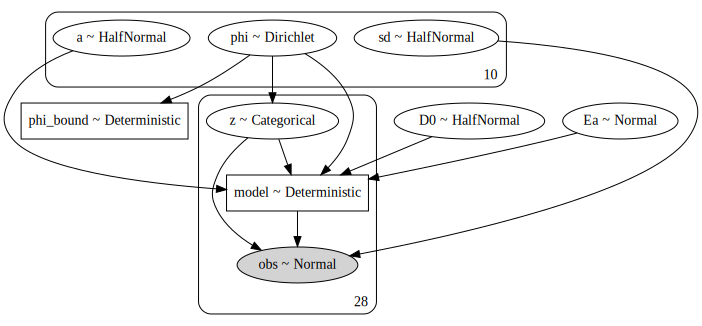

In [35]:
r = pm.model_to_graphviz(Q)
r

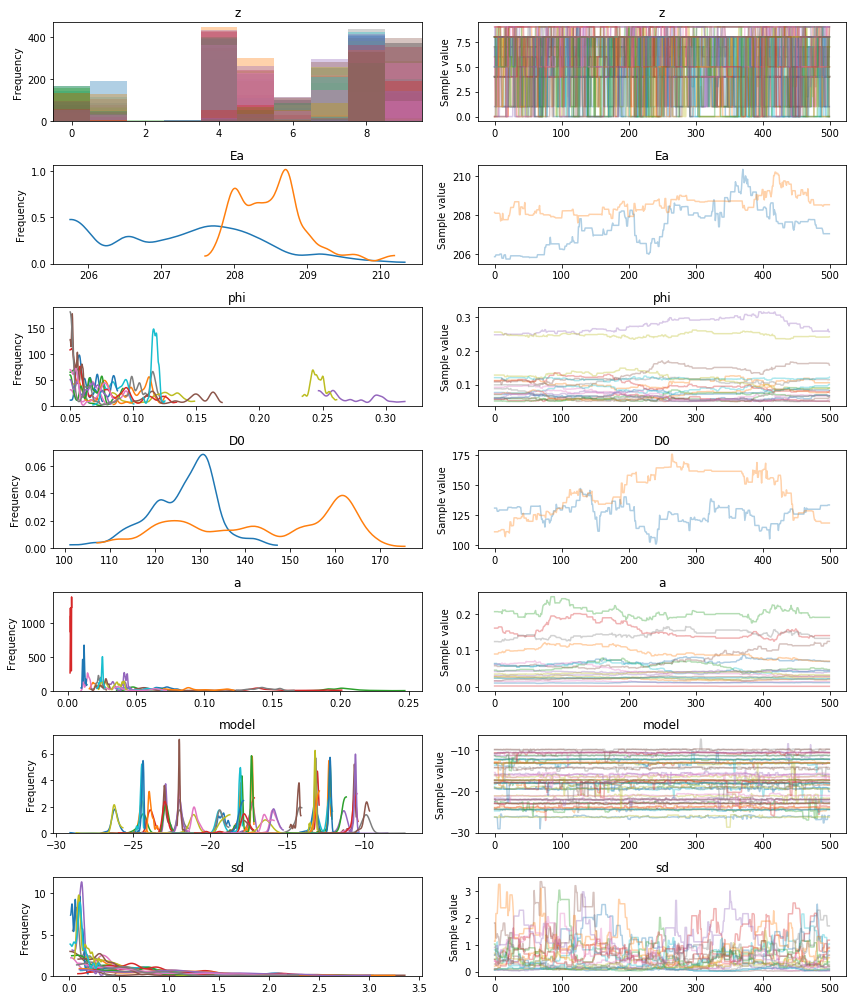

In [36]:
pm.traceplot(trace[-500:]); 

In [37]:
pm.summary(trace); 

In [38]:
with Q: 
    ppc = pm.sample_ppc(trace[-5000:], 1000)

/Applications/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: sample_ppc() is deprecated.  Please use sample_posterior_predictive()
  
100%|██████████| 1000/1000 [00:01<00:00, 856.82it/s]


Text(0, 0.5, 'ln(D/a$^{2}$)')

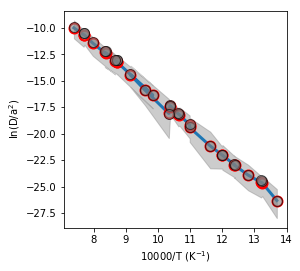

In [39]:
plt.figure(figsize = (4,4))
plt.plot(tplot,ppc['obs'].mean(axis = 0), '-o', 
        markeredgewidth =2 , markeredgecolor = 'r', markerfacecolor = 'None', 
        ms = 10, lw = 3);
#plt.plot(tplot, trace['model'].mean(axis = 0).mean(axis = 0), '-o', 
#        markeredgewidth =2 , markeredgecolor = 'r', 
#         markerfacecolor = 'None', 
#        ms = 10, lw = 3)
plt.plot(tplot,data, 'o', 
          color= 'grey', markeredgecolor = 'k', ms = 10, 
         alpha = 0.6) 
low, high = np.percentile(ppc['obs'], [2.5, 97.5], 
                         axis = 0)
plt.fill_between(tplot, low, high, color = 'grey', 
                alpha = 0.4)
plt.xlabel('10000/T (K$^{-1}$)')
plt.ylabel('ln(D/a$^{2}$)')

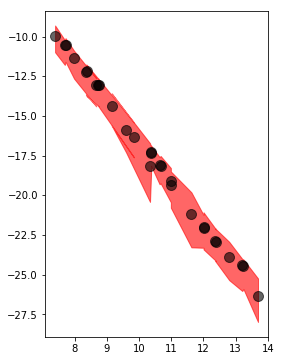

In [40]:
low, high = np.percentile(ppc['obs'][-5000:], [2.5, 97.5], 
                         axis = 0)
plt.figure(figsize = (4,6))
plt.fill_between(tplot, low, high, color = 'r', 
                alpha = 0.6)
plt.plot(tplot,data, 'o', 
          color= 'k', markeredgecolor = 'k', ms = 10, 
         alpha = 0.6) 

# Number of Domains

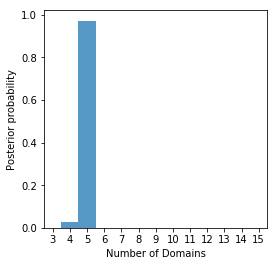

In [42]:
n_domains = np.apply_along_axis(lambda x: np.unique(x).size,
                                1, 
                                trace['z'][-1000:])
fig, ax = plt.subplots(figsize=(4, 4))

bins = np.arange(0, 6+ 1)
ax.hist(n_domains + 1, bins=bins, normed=True,
        lw=3, alpha=0.75);


bins = np.arange(n_domains.min(),
                 n_domains.max() + 10)
ax.set_xticks(bins + 0.5);
ax.set_xticklabels(bins);
ax.set_xlim(bins.min(), bins.max() + 1);
ax.set_xlabel('Number of Domains');
#ax.set_ylim(0,0.0001)

ax.set_ylabel('Posterior probability');

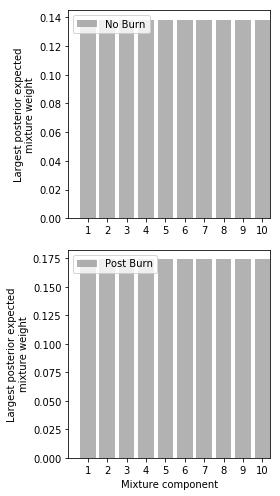

In [245]:
fig, ax = plt.subplots(2,1,figsize = (4,7))
ax[0].bar(np.arange(k) + 1, 
      trace['phi'].mean(axis = 0).max(axis = 0), 
      label = 'No Burn', alpha = 0.6, lw = 2, 
         color = 'grey'); 

ax[1].bar(np.arange(k) + 1, 
      trace['phi'][-10000::2].mean(axis = 0).max(axis = 0), 
      label = 'Post Burn', lw = 2, alpha = 0.6, 
         color = 'grey')
ax[0].set_xticks(np.arange(0, k, 1) + 1); 
ax[0].legend()
ax[0].set_xlim(0, 10 + 0.4)
ax[0].set_ylabel('Largest posterior expected\nmixture weight')



ax[1].set_xticks(np.arange(0, k, 1) + 1); 
ax[1].legend()
ax[1].set_xlim(0, 10 + 0.4)
ax[1].set_xlabel('Mixture component')
ax[1].set_ylabel('Largest posterior expected\nmixture weight')



plt.tight_layout()

In [ ]:
plt.plot(trace['w'].mean(axis = 0));

In [306]:
ml = Q.logp
logp = [ml(i) for i in trace]

plt.plot(logp)

KeyboardInterrupt: 

In [ ]:
tr_a = approx.sample(1000)
plt.traceplot(tr_a); 

# Plotting Phi Estimates

In [ ]:
def plot_phi_estimates(trace): 
    for j in range(k):
        sns.distplot(trace['phi'][:, j], kde = True, 
                    hist = False, kde_kws ={"lw":2})
        plt.xlim(0,trace['phi'].max() + 0.1)
        

In [ ]:
font = {'family' : 'Arial',
        'weight' : 'normal',
        'size'   : 13}
plt.rc('font', **font)

#### Phi ######
plt.figure(figsize = (4,4)); 
plot_phi_estimates(trace[-600:]); 
plt.xlabel('$\phi$'); 
plt.ylabel('Probability  Density'); 
plt.tight_layout()
plt.savefig('tremblay_model4.pdf')

# Plotting Grain Radii Estimates

In [ ]:
def plot_a_estimates(trace): 
    for j in range(k):
        sns.distplot(trace['a'][:, j], kde = True, 
                    hist = False, kde_kws ={"lw":2})
        plt.xlim(0,trace['a'].max() + 0.0005)

In [ ]:
#### a ######
plt.figure(figsize = (4,4)); 
plot_a_estimates(trace); 
plt.xlabel('$a$'); 
plt.ylabel('Probability  Density'); 
plt.ylim(0, 500)

# Plot Activation Energy Estimates 

In [259]:
def plot_Ea_estimates(trace): 
    for j in range(k):
        sns.distplot(trace['Ea'][:, j], kde = True, 
                    hist = False, kde_kws ={"lw":2})
        plt.xlim(trace['Ea'].min() - 6,trace['Ea'].max() + 5)
        plt.ylim(0,0.7)

In [260]:
#### Ea ######
plt.figure(figsize = (4,4)); 
plot_Ea_estimates(trace); 
plt.xlabel('$E_a$'); 
plt.ylabel('Probability  Density'); 

IndexError: too many indices for array

<Figure size 320x320 with 0 Axes>

# Plot Frequency Factor Estimates 

In [261]:
def plot_D0_estimates(trace): 
    for j in range(k):
        sns.distplot(trace['D0'][:, j], kde = True, 
                    hist = False, kde_kws ={"lw":2})
        plt.xlim(trace['D0'].min() - 6,trace['D0'].max() + 5)
        plt.ylim(0,0.7)

In [262]:
#### D0 ######
plt.figure(figsize = (4,4)); 
plot_D0_estimates(trace); 
plt.xlabel('$D_0$'); 
plt.ylabel('Probability  Density'); 

IndexError: too many indices for array

<Figure size 320x320 with 0 Axes>